In [24]:
# KMeans

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import sklearn.datasets
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from scipy.spatial import distance

style.use('Solarize_Light2')

In [22]:
np.random.seed(42)

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

class KMean():
    def __init__(self, K=8, max_iters=100, plot_steps=False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps
        self.clusters = [[] for _ in range(self.K)]
        self.centroids = []

    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]
        for _ in range(self.max_iters):
            self.clusters = self._create_clusters(self.centroids)
            if self.plot_steps:
                self.plot()
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)
            if self._is_converged(centroids_old, self.centroids):
                break
            if self.plot_steps:
                self.plot()
        return self._get_cluster_labels(self.clusters)

    def _get_cluster_labels(self, clusters):
        labels = np.empty(self.n_samples)

        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_idx
        return labels

    def _create_clusters(self, centroids):
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _closest_centroid(self, sample, centroids):
        distances = [euclidean_distance(sample, point) for point in centroids]
        closest_index = np.argmin(distances)
        return closest_index

    def _get_centroids(self, clusters):
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _is_converged(self, centroids_old, centroids):
        distances = [euclidean_distance(centroids_old[i], centroids[i]) 
        for i in range(self.K)]
        return sum(distances) == 0

    def plot(self):
        fig, ax = plt.subplots(figsize=(12, 8))
        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)
        for point in self.centroids:
            ax.scatter(*point, marker="x", color='black', linewidth=2)
        plt.show()

In [23]:
df = pd.read_csv('kmean_dataset.csv')
X = df.iloc[:,[0,1,2]].values

def compute_bic(kmeans,X):
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    m = kmeans.n_clusters
    n = np.bincount(labels)
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 'euclidean')**2) for i in range(m)])
    const_term = 0.5 * m * np.log(N) * (d+1)
    BIC = np.sum([n[i] * np.log(n[i]) - n[i] * np.log(N) - ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) - ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term
    return(BIC)

KMeans = [cluster.KMeans(n_clusters = i, init="k-means++",random_state=0).fit(X) for i in range(1,10)]

In [25]:
BIC = [compute_bic(i,X) for i in KMeans]
print(f"Value of BIC: ")
for i in BIC:
    print(i)
print(f"\nMaximum value of BIC: {max(BIC)}")
print(f"\nValue of K: {BIC.index(max(BIC))+1}")

Value of BIC: 
-711.3188522095594
-482.5398990071221
-411.6283213921009
-380.8575173003059
-373.70503045378643
-372.98899116766205
-367.0469068841177
-370.79965082372894
-381.822081413338

Maximum value of BIC: -367.0469068841177

Value of K: 7


Text(0, 0.5, 'BIC')

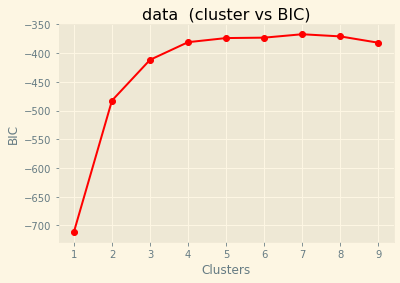

In [26]:
plt.plot(ks,BIC,'r-o')
plt.title("data  (cluster vs BIC)")
plt.xlabel("Clusters")
plt.ylabel("BIC")